# Energy MetaFormer

This notebook provides a simple numerical demonstration of *Energy MetaFormer* presented in Section 4 of the paper "Hierarchical Associative Memory, Parallelized MLP-Mixer, and Symmetry Breaking," [arXiv:2406.12220](https://arxiv.org/abs/2406.12220).

The results of Figures 2b & 2c in the paper can be reproduced by the following three steps:

1. Download & preprocess the MNIST dataset
1. Define & train the model
1. Visualization of the receptive fields & energy descent

For more details, see Section 4.2 of the paper.


This notebook and the implementation are based on the "Barebones HAMUX" repository:

- https://github.com/bhoov/barebones-hamux
    - cf. https://github.com/bhoov/hamux

## Prepare requirements/utils

In [ ]:
!pip install datasets einops equinox  jax optax tqdm

In [ ]:
# ../util/hamux.py

"""HAMUX, a minimal implementation of the Hierarchical Associative Memory

HAMUX is the skeleton of what could be an entirely new way to build DL architectures using energy blocks.
"""
# source: https://github.com/bhoov/barebones-hamux/blob/main/bbhamux.py

from typing import Union, Callable, Tuple, Dict, List, Optional
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import jax.random as jr
import equinox as eqx


class Neurons(eqx.Module):
    """Neurons represent dynamical variables in HAM that are evolved during inference (i.e., memory retrieval / error correction)

    They have an evolving state (created using the `.init` function) that is stored outside the neuron layer itself
    """

    lagrangian: Union[Callable, eqx.Module]
    shape: Tuple[int]

    def __init__(
            self,
            lagrangian: Union[Callable, eqx.Module],
            shape: Union[int, Tuple[int]],
            ):
        self.lagrangian = lagrangian
        if isinstance(shape, int):
            shape = (shape,)
        self.shape = shape

    def __repr__(self: jax.Array):
        return f"Neurons(lagrangian={self.lagrangian}, shape={self.shape})"

    def init(self, bs: Optional[int] = None) -> jax.Array:  # bs: batch size
        """Initialize the states of this layer, with correct shape.

        If `bs` is provided, return tensor of shape (bs, *self.shape), otherwise return self.shape
        By default, initialize layer state to all 0.
        """
        if bs is None or bs == 0:
            return jnp.zeros(self.shape)
        return jnp.zeros((bs, *self.shape))

    def activations(self, x: jax.Array) -> jax.Array:
        """Compute the activations of the neuron layer, the derivative of the Lagrangian"""
        return jax.grad(self.lagrangian)(x)

    def g(self, x: jax.Array) -> jax.Array:
        """Alias for the `activations`"""
        return self.activations(x)

    def energy(
            self,
            g: jax.Array,
            x: jax.Array,
            ) -> jax.Array:
        """Compute the energy. Assume neurons are vectorized"""
        return jnp.multiply(g, x).sum() - self.lagrangian(x)


#* Example Lagrangians
"""Default Lagrangian functions that correspond to commonly used non-linearities in neural networks.

1. Lagrangians return a scalar
2. Lagrangians are convex
3. The derivative of a Lagrangian w.r.t. its input is the activation function typically used in neural networks

"""

def lagr_identity(x):
    """The Lagrangian whose activation function is simply the identity."""
    return 0.5 * jnp.power(x, 2).sum()

def lagr_repu(x, n):
    """Rectified Power Unit of degree `n`"""  # n: degree of the polynomial in the power unit
    return 1 / n * jnp.power(jnp.maximum(x, 0), n).sum()

def lagr_relu(x):
    """Rectified Linear Unit. Same as `repu` of degree 2"""
    return lagr_repu(x, 2)

def lagr_softmax(
        x: jnp.ndarray,
        beta: float = 1.0,  # inverse temperature
        axis: int = -1,  # axis over which to apply logsumexp
        ):
    """The Lagrangian of the softmax -- the logsumexp"""
    return 1 / beta * jax.nn.logsumexp(beta * x, axis=axis, keepdims=False)

def lagr_layernorm(
        x: jnp.ndarray,
        gamma: float = 1.0,  # scale the std
        delta: Union[float, jnp.ndarray] = 0.0,  # shift the mean
        axis: int = -1,  # which axis to normalize
        eps: float = 1e-5,  # prevent division by 0
        ):
    """Lagrangian of the layer norm activation function"""

    D = x.shape[axis] if axis is not None else x.size
    xmean = x.mean(axis, keepdims=True)
    xmeaned = x - xmean
    y = jnp.sqrt(jnp.power(xmeaned, 2).mean(axis, keepdims=True) + eps)

    return (D * gamma * y + (delta * x).sum()).sum()

def lagr_spherical_norm(
        x: jnp.ndarray,
        gamma: float = 1.0,  # scale the std
        delta: Union[float, jnp.ndarray] = 0.0,  # shift the mean
        axis: int = -1,  # which axis to normalize
        eps: float = 1e-5,  # prevent division by 0
        ):
    """Lagrangian of the spherical norm activation function"""

    y = jnp.sqrt(jnp.power(x, 2).sum(axis, keepdims=True) + eps)

    return (gamma * y + (delta * x).sum()).sum()


#* Example Synapses
class DenseSynapse(eqx.Module):
    """The simplest of dense (linear) functions that defines the energy between two layers"""

    W: jax.Array

    def __init__(
            self,
            key: jax.Array,
            g1_dim: int,
            g2_dim: int,
            ):
        super().__init__()
        # simplest initialization
        self.W = 0.02 * jr.normal(key, (g1_dim, g2_dim)) #+ 0.2

    @property
    def nW(self):
        nc = jnp.sqrt(jnp.sum(self.W ** 2, axis=0, keepdims=True))
        return self.W / nc

    def __call__(
            self,
            g1: jax.Array,
            g2: jax.Array,
            ):
        """Compute the energy between activations g1 and g2.

        The more aligned, the lower the energy"""
        return -jnp.einsum("...c,...d,cd->...", g1, g2, self.W)

class DenseSynapseHid(eqx.Module):
    W: jax.Array
    def __init__(
            self,
            key: jax.Array,
            d1: int,
            d2: int,
            ):
        super().__init__()
        self.W = 0.02 * jr.normal(key, (d1, d2)) + 0.2

    @property
    def nW(self):
        nc = jnp.sqrt(jnp.sum(self.W ** 2, axis=0, keepdims=True))
        return self.W / nc

    def __call__(self, g1: jax.Array):
        """Compute the energy of the synapse.

        Here logsumexp lagrangian is assumed"""
        x2 = g1 @ self.nW
        beta = 1e1
        return - 1/beta * jax.nn.logsumexp(beta * x2, axis=-1)


class HAM(eqx.Module):
    """The Hierarchical Associative Memory

    A wrapper for all dynamic states (neurons) and learnable parameters (synapses) of our memory
    """

    neurons: Dict[str, Neurons]
    synapses: Dict[str, eqx.Module]
    connections: List[Tuple[Tuple, str]]

    def __init__(
            self,
            neurons: Dict[str, Neurons],  # Neurons are the dynamical variables expressing the state of the HAM
            synapses: Dict[str, eqx.Module],  # Synapses are the learnable relationships between dynamic variables.
            connections: List[Tuple[Tuple[str, ...], str]],  # Connections expressed as [(['ni', 'nj'], 'sk'), ...]. Read as "Connect neurons 'ni' and 'nj' via synapse 'sk'
            ):
        """An HAM is a hypergraph that connects neurons and synapses together via connections"""
        self.neurons = neurons
        self.synapses = synapses
        self.connections = connections

    @property
    def n_neurons(self) -> int:
        return len(self.neurons)

    @property
    def n_synapses(self) -> int:
        return len(self.synapses)

    @property
    def n_connections(self) -> int:
        return len(self.connections)

    def init_states(self, bs: Optional[int] = None):  # If provided, each neuron in the HAM has this batch size
        """Initialize neuron states"""
        xs = {k: v.init(bs) for k, v in self.neurons.items()}
        return xs

    def activations(
            self,
            xs: Dict[str, jax.Array],  # The expected collection of neurons states
            ) -> Dict[str, jax.Array]:
        """Convert hidden states of each neuron into activations"""
        gs = {k: v.g(xs[k]) for k, v in self.neurons.items()}
        return gs

    def neuron_energies(
            self,
            gs: Dict[str, jax.Array],
            xs: Dict[str, jax.Array],
            ):
        """Return the energies of each neuron in the HAM"""
        return {k: self.neurons[k].energy(gs[k], xs[k]) for k in self.neurons.keys()}

    def connection_energies(
        self,
        gs: Dict[str, jax.Array],  # The collection of neuron activations
    ):
        """Get the energy for each connection

        A function of the activations `gs` rather than the states `xs`
        """

        def get_energy(neuron_set, s):
            temp = [gs[k] for k in neuron_set]
            return self.synapses[s](*temp)

        return [get_energy(neuron_set, s) for neuron_set, s in self.connections]

    def energy_tree(self, gs, xs):
        """Return energies for each individual component"""
        neuron_energies = self.neuron_energies(gs, xs)
        connection_energies = self.connection_energies(gs)
        return {"neurons": neuron_energies, "connections": connection_energies}

    def energy(self, gs, xs):
        """The complete energy of the HAM"""
        energy_tree = self.energy_tree(gs, xs)
        return jtu.tree_reduce(lambda E, acc: acc + E, energy_tree, 0)

    def dEdg(
            self,
            gs,
            xs,
            return_energy=False,
            ):
        """Calculate the gradient of system energy w.r.t. activations using cute trick:

        The derivative of the neuron energy w.r.t. the activations is the neuron state itself.
        This is a property of the Legendre transform:
        dE_layer / dg = x
        """

        def all_connection_energy(gs):
            return jtu.tree_reduce(lambda E, acc: acc + E, self.connection_energies(gs), 0)

        dEdg = jtu.tree_map(lambda x, s: x + s, xs, jax.grad(all_connection_energy)(gs))  # xs = dE_layers / dgs
        if return_energy:
            return self.energy(gs, xs), dEdg
        return jax.grad(self.energy)(gs, xs)

    def vectorize(self):
        """Compute a new HAM with same API, all methods expect batch dimension"""
        return VectorizedHAM(self)

    def unvectorize(self):
        return self


class VectorizedHAM(eqx.Module):
    """Re-expose HAM API with vectorized inputs. No logic should be implemented in this class."""

    _ham: eqx.Module

    def __init__(self, ham):
        self._ham = ham

    @property
    def neurons(self):
        return self._ham.neurons

    @property
    def synapses(self):
        return self._ham.synapses

    @property
    def connections(self):
        return self._ham.connections

    @property
    def n_neurons(self):
        return self._ham.n_neurons

    @property
    def n_synapses(self):
        return self._ham.n_synapses

    @property
    def n_connections(self):
        return self._ham.n_connections

    @property
    def _batch_axes(self: HAM):
        """A helper function to tell vmap to batch along the 0th dimension of each state in the HAM."""
        return {k: 0 for k in self._ham.neurons.keys()}

    def init_states(self, bs=None):
        """Initialize neuron states with batch size `bs`"""
        return self._ham.init_states(bs)

    def activations(self, xs):
        """Compute activations of a batch of inputs"""
        return jax.vmap(self._ham.activations, in_axes=(self._batch_axes,))(xs)

    def neuron_energies(self, gs, xs):
        """Compute energy of every neuron in the HAM"""
        return jax.vmap(self._ham.neuron_energies, in_axes=(self._batch_axes, self._batch_axes))(gs, xs)

    def connection_energies(self, gs):
        """Compute energy of every connection in the HAM"""
        return jax.vmap(self._ham.connection_energies, in_axes=(self._batch_axes,))(gs)

    def energy_tree(self, gs, xs):
        """Return energies for each individual component"""
        return jax.vmap(self._ham.energy_tree, in_axes=(self._batch_axes, self._batch_axes))(gs, xs)

    def energy(self, gs, xs):
        """Compute the energy of the entire HAM"""
        return jax.vmap(self._ham.energy, in_axes=(self._batch_axes, self._batch_axes))(gs, xs)

    def dEdg(self, gs, xs, return_energy=False):
        """Compute the gradient of the energy wrt the activations of the HAM"""
        return jax.vmap(self._ham.dEdg, in_axes=(self._batch_axes, self._batch_axes, None))(gs, xs, return_energy)

    def unvectorize(self):
        """Return an HAM energy that does not work on batches of inputs"""
        return self._ham

    def vectorize(self):
        return self

In [ ]:
# ../util/ham_utils.py

#import jax.numpy as jnp
#import jax.tree_util as jtu
#import jax.random as jr
#import equinox as eqx


# for step 1: normalization
from einops import rearrange

def transform(x):
    x = x / 255.
    x = rearrange(x, "... h w -> ... (h w)")
    x = x / jnp.sqrt((x ** 2).sum(-1, keepdims=True))
    return x


# for step 2:
import optax

def lossf(
        ham,
        xs,
        key,
        nsteps=1,  # number of steps to update
        alpha=1.,  # step size to take in direction of updates
        ):
    """Given a noisy initial image, descend the energy and try to reconstruct the original image at the end of the dynamics.

    Works best with fewer steps due to vanishing gradient problems"""
    input = xs['input']
    xs['input'] = input + jr.normal(key, input.shape) * 0.3

    for _ in range(nsteps):
        # Construct noisy image to final prediction
        gs = ham.activations(xs)
        evalue, egrad = ham.dEdg(gs, xs, return_energy=True)
        xs = jtu.tree_map(lambda x, dEdg: x - alpha * dEdg, xs, egrad)  # The negative of our dEdg, computing the update direction each layer should descend

    gs = ham.activations(xs)
    output = gs['input']
    loss = ((output - input)**2).mean()

    logs = {
        "loss": loss,
    }
    return loss, logs

@eqx.filter_jit
def step(
    input,
    ham,
    opt_state,
    key,
    opt=None,  # optax.adam(lr)
    nsteps=1,  # number of steps to update
    alpha=1.,  # step size to take in direction of updates
    ):
    xs = ham.init_states(bs=input.shape[0])
    xs['input'] = input

    (loss, logs), grads = eqx.filter_value_and_grad(lossf, has_aux=True)(ham, xs, key, nsteps=nsteps, alpha=alpha)
    updates, opt_state = opt.update(grads, opt_state, ham)
    newparams = optax.apply_updates(eqx.filter(ham, eqx.is_array), updates)
    ham = eqx.combine(newparams, ham)
    return ham, opt_state, logs


import json

def save_hyper_model(filename, hyperparams, model):
    with open(filename, "wb") as f:
        hyperparam_str = json.dumps(hyperparams)
        f.write((hyperparam_str + "\n").encode())
        eqx.tree_serialise_leaves(f, model)

def load_hyper_model(filename, model):
    with open(filename, "rb") as f:
        hyperparams = json.loads(f.readline().decode())
        model_ = model
        return hyperparams, eqx.tree_deserialise_leaves(f, model_)


# for step 3:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# set the colormap and the colorbar
class MidpointNormalize(Normalize):
    """Normalise the colorbar."""
    def __init__(
            self,
            vmin=None,
            vmax=None,
            midpoint=None,
            clip=False,
            ):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

def show_img(img, figsize=(6, 6)):
    vmin, vmax = img.min(), img.max()
    vscale = max(np.abs(vmin), np.abs(vmax))
    cnorm = MidpointNormalize(midpoint=0., vmin=-vscale, vmax=vscale)

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    pcm = ax.imshow(img, cmap="seismic", norm=cnorm)
    ax.axis("off")

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.83, 0.15, 0.03, 0.7])
    fig.colorbar(pcm, cax=cbar_ax);
    return fig

## Train on MNIST

1. Download and preprocess the MNIST dataset
1. Define and train the model
1. Visualization of the result

### 1 Download and preprocess dataset

In [ ]:
import datasets

mnist = datasets.load_dataset("mnist").with_format("jax")
train_set = mnist['train']
test_set  = mnist['test']

In [ ]:
Xtrain = next(train_set.iter(len(train_set)))['image']
Xtest  = next(test_set.iter(len(test_set)))['image']

Xtrain = transform(Xtrain)
Xtest  = transform(Xtest)

### 2 Define and train the model

In [ ]:
# Set hyperparameters

v_dim = 784; h_dim = 900

n_epochs = 100
batch_size = 512
lr = 1e-4

nsteps = 10
alpha = 0.1

hyperparameters = {
    "v_dim": v_dim,
    "h_dim": h_dim,
    "lr": lr,
    "epochs": n_epochs,
    "batch_size": batch_size,
    "n_steps": nsteps,
    "alpha": alpha,
    }

In [ ]:
# Instantiate model

key = jr.PRNGKey(0)
skey, key = jax.random.split(key)
ckey, key = jax.random.split(key)


neurons = {
    "xs": Neurons(lagr_relu, (h_dim,)),
    "input": Neurons(lagr_layernorm, (v_dim,)),  # "xv"
    "xc": Neurons(lagr_relu, (h_dim,)),
}

synapses = {
    "xi_sv": DenseSynapse(skey, h_dim, v_dim),
    "xi_vc": DenseSynapse(ckey, v_dim, h_dim),
}

connections = [
    (["xs", "input"], "xi_sv"),
    (["input", "xc"], "xi_vc"),
]


ham = HAM(neurons, synapses, connections)
ham

HAM(
  neurons={
    'xs':
    Neurons(lagrangian=<function lagr_relu>, shape=(900,)),
    'input':
    Neurons(lagrangian=<function lagr_layernorm>, shape=(784,)),
    'xc':
    Neurons(lagrangian=<function lagr_relu>, shape=(900,))
  },
  synapses={
    'xi_sv':
    DenseSynapse(W=f32[900,784]),
    'xi_vc':
    DenseSynapse(W=f32[784,900])
  },
  connections=[(['xs', 'input'], 'xi_sv'), (['input', 'xc'], 'xi_vc')]
)

In [ ]:
# Train the model

from tqdm.auto import tqdm

pbar = tqdm(range(n_epochs), total=n_epochs)
img = Xtrain[:]

ham = ham.vectorize()
opt = optax.adam(lr)
opt_state = opt.init(eqx.filter(ham, eqx.is_array))


noise_rng = jr.PRNGKey(100)
batch_rng = jr.PRNGKey(10)
for e in pbar:
    batch_key, batch_rng = jr.split(batch_rng)
    idxs = jr.permutation(batch_key, jnp.arange(img.shape[0]))

    i = 0
    while i < img.shape[0]:
        noise_key, noise_rng = jr.split(noise_rng)
        batch = img[idxs[i: i + batch_size]]
        ham, opt_state, logs = step(batch, ham, opt_state, noise_key, opt=opt, nsteps=nsteps, alpha=alpha)
        i += batch_size

        pbar.set_description(f'[{i}]: epoch = {e+1:03d}/{n_epochs:03d}, loss = {logs["loss"].item():2.6f}')

  0%|          | 0/100 [00:00<?, ?it/s]

#### Save and/or load model

In [ ]:
dir = '/path/to/checkpoints/'
model_path = 'em_b512_lr0001.eqx'

save_hyper_model(dir + model_path, hyperparameters, ham)
hyperparams_loaded, ham_loaded = load_hyper_model(dir + model_path, model=ham)

# Check that it's saved & loaded correctly:
assert ham.synapses['xi_sv'].W[0,0] == ham_loaded.synapses['xi_sv'].W[0,0]

print(hyperparams_loaded)
ham.synapses['xi_sv'].W

### 3 Visualization

Visualize receptive fields and energy descent

In [ ]:
# The above architecture trains ok, learns some decent prototypes. Not perfect

Wvc = ham_loaded.synapses["xi_vc"].W  # (784, 900)
indexlist = jnp.argsort(jnp.linalg.norm(Wvc.T, axis=1))
sortedW = Wvc[:,indexlist]
nc = jnp.sqrt(jnp.sum(sortedW ** 2, axis=0, keepdims=True))

kh = kw = int(np.sqrt(Wvc.shape[-1]))  # Wvc.shape[-1] = h_dim

size2 = 100
size  = int(np.sqrt(size2))

figsize = (12, 12)
show_img(rearrange(Wvc, "(h w) (kh kw) -> (kh h) (kw w)", h=28, w=28, kh=kh, kw=kw), figsize=figsize);  # (784, 900) --> (30*28, 30*28)
show_img(rearrange((sortedW/nc)[:, -size2:], "(h w) (kh kw) -> (kh h) (kw w)", h=28, w=28, kh=size, kw=size), figsize=figsize);  # (784, 100) --> (10*28, 10*28)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Wsv = ham_loaded.synapses["xi_sv"].W  # (900, 784)
indexlist = jnp.argsort(jnp.linalg.norm(Wsv, axis=1))
sortedW_ = Wsv[indexlist,:]
nc_ = jnp.sqrt(jnp.sum(sortedW_ ** 2, axis=1, keepdims=True))

kh = kw = int(np.sqrt(Wsv.shape[0]))  # sqrt(h_dim)

size2 = 100
size  = int(np.sqrt(size2))

figsize = (12, 12)
show_img(rearrange(Wsv, "(kh kw) (h w) -> (kh h) (kw w)", h=28, w=28, kh=kh, kw=kw), figsize=figsize);  # (900, 784) --> (30*28, 30*28)
show_img(rearrange((sortedW_/nc_)[-size2:, :], "(kh kw) (h w) -> (kh h) (kw w)", h=28, w=28, kh=size, kw=size), figsize=figsize);

Output hidden; open in https://colab.research.google.com to view.

#### Check energy descent

In [ ]:
@eqx.filter_jit
def new_dedg(ham, xs):
    gs = ham.activations(xs)
    energy, dEdg = ham.dEdg(gs, xs, return_energy=True)
    return energy, dEdg

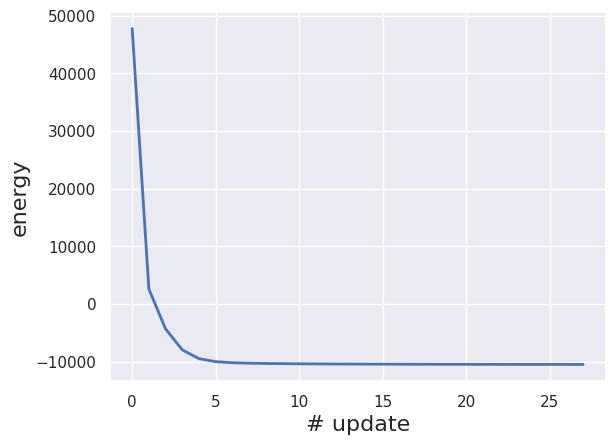

In [ ]:
key = jr.PRNGKey(0)

xs = ham_loaded.init_states()
xs = {k: 10*jr.normal(key, xs[k].shape) for k in xs.keys()}
gs = ham_loaded.activations(xs)

nsteps = 28
energies = jnp.empty(nsteps)
for i in range(nsteps):
    energy, dEdg = new_dedg(ham_loaded, xs)
    energies = energies.at[i].set(energy)

    xs = jtu.tree_map(lambda x, u: x - 0.5 * u, xs, dEdg)


plt.plot(jnp.stack(energies), linewidth=2)
plt.xlabel("# update", fontsize=16)
plt.ylabel("energy", fontsize=16)
plt.show()